# TP : Decision trees and ensemble methods

*Authors: Aymeric François & Benjamin Ternot*

In the first part, you are asked to implement a **Stump**, i.e. a decision tree of depth 1, from scratch. Our tree should be able to handle weighted and unweighted samples, in order for it to be used as a weak learner for
**AdaBoost** in the second part.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_moons, make_circles, make_classification

The following code creates 3 synthetic datasets, in which there are just two features, for binary classification. We ask you to provide the solutions to the exercises on all elements of the list ```datasets```.

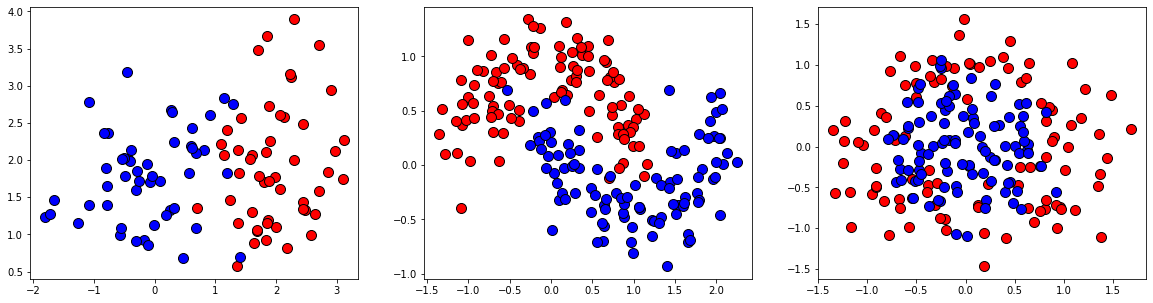

In [2]:
plot_colors = "rb"
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [linearly_separable,
            make_moons(n_samples = 200, noise=0.2, random_state=0),
            make_circles(n_samples = 200, noise=0.3, factor=0.5, random_state=1)
            ]

fig, ax = plt.subplots(1, 3, figsize=(20,5))
for fi in range(len(datasets)):
    dataset = datasets[fi]
    X = dataset[0]
    y = dataset[1]
    n_classes = len(np.unique(y))
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        ax[fi].scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.RdYlBu, edgecolor='black', s=100)
dataset = datasets[1]

In [3]:
def plot_tree(clf, X, y, label=None):
    n_classes = 2
    plot_colors = "rb"
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("tight")
    if label:
        plt.title(label)
    # Plot the training points
    for i, color in zip([-1,1], plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)
    plt.show()

## First part: Stumps

In this first part, you will code your own class to handle stumps for 2-dimensional data and binary classification (i.e., the class takes value in $\{0, 1\}$). You can find the outline of the code you will need to write, following these instructions:
- Implement the ```fit``` method : since the weak learners are potentially executed a large number of times, efficiency is crucial. Use the incremental evaluation of the partitions seen in class : the complexity should be  $O(ndc)$ instead of the naive $O(n^2 dc)$ version. We assume that the sorting operations such as ```argsort``` are free because we only need to run them once. Iterate in the 2-dimensions for every possible split, evaluate the quality of each split using an incremental version of the Gini index (defined next) and store the best split. (Note : a non-incremental version will be graded with half the points)
- Implement the ```gini``` method : Implement the Gini index coefficient for the case in which there are only 2 classes. In class, you saw the unweighted case: we quickly recall the unweighted then weighted version. Let $C$ be the number of different classes, $p_k(S)$ be the ratio of datapoints of class $k$ in region $S$. Then, the Gini index $G(S)$ is $$ G(S) = 1 - \sum_{k=1}^{C} p_k(S)^2$$ Given a split in which we have left and right regions $S_r$, $S_l$, let $N_r$ (resp. $N_l$) be the number of datapoints in $S_r$ (resp. $S_l$). The Gini index of the split is the combination of the Gini index of both regions: $$ \frac{N_r}{N_r + N_l}G(S_r) + \frac{N_l}{N_r + N_l}G(S_l) $$ For generalizing to the weighted case, let $w_k(S)$ be the sum of the weights of all data-points of class $k$ in $S$. The Gini index is defined as follows: $$ G(S) = 1 - \sum_{k=1}^{C} \left( \frac{w_k(S)}{  \sum_{m=1}^{C} w_m(S)} \right)^2 $$ Given a split in which we have left and right regions $S_r$, $S_l$, let $W_r = \sum_{k=1}^{C} w_k(S)$ (resp. $W_l$) the total weight on $S_r$ (resp. $S_l$). The Gini index of the partition is the combination of the Gini index of both regions: $$ \frac{W_r}{W_r + W_l}G(S_r) + \frac{W_l}{W_r + W_l}G(S_l) $$
- Implement the ```predict``` method. The input is an array of $n$ $d$-dimensional observations. The output is a ```np.array``` of length $n$. Once the ```predict``` method is coded, use the given function ```plot_tree(my_stump, X, y)``` to plot ```my_stump``` on each of the ```datasets```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [4]:
from sklearn import tree

class My_stump:
    def __init__(self):
        self.best_dimension = None
        self.best_threshold = None
        self.class_below_threshold = None
        self.class_above_threshold = None
        self.best_ev = None
        
    def get_threshold(self): return self.best_threshold
  
    def get_best(self): return self.best_dimension,  self.best_threshold, self.best_ev
    
    def gini_impurity(self, y, sample_weight=None):
        classes = np.unique(y)
        impurity = 1
        for c in classes:
            impurity -= (np.sum(sample_weight[y == c]) / np.sum(sample_weight)) ** 2
        return impurity
        
    def fit(self, X, y, sample_weight=None):
        n_samples, n_features = X.shape
        if sample_weight is None:
            sample_weight = np.ones(n_samples)
        best_impurity = np.inf
        for i in range(n_features):
            sorted_feature = np.argsort(X[:, i])
            class_below_threshold, class_above_threshold = [], []
            for j in range(n_samples - 1):
                if X[sorted_feature[j], i] != X[sorted_feature[j + 1], i]:
                    threshold = (X[sorted_feature[j], i] + X[sorted_feature[j + 1], i]) / 2
                    below_bin = X[:, i] <= threshold
                    above_bin = X[:,i] > threshold
                    impurity_below = self.gini_impurity(y[below_bin], sample_weight[below_bin])
                    impurity_above = self.gini_impurity(y[above_bin], sample_weight[above_bin])
                    impurity_sum = (impurity_below * np.sum(sample_weight[below_bin]) + impurity_above * np.sum(sample_weight[above_bin]))
                    if impurity_sum < best_impurity:
                        best_impurity = impurity_sum
                        self.best_dimension = i
                        self.best_threshold = threshold
                        unique_vals_below, val_indices_below = np.unique(y[below_bin], return_inverse=True)
                        counts_below = np.zeros(len(unique_vals_below), dtype=np.int64)
                        below_count = np.add.at(counts_below, val_indices_below, sample_weight[below_bin])
                        unique_vals_above, val_indices_above = np.unique(y[above_bin], return_inverse=True)
                        counts_above = np.zeros(len(unique_vals_above), dtype=np.int64)
                        above_count = np.add.at(counts_above, val_indices_above, sample_weight[above_bin])
                        self.class_below_threshold = np.argmax(below_count)
                        self.class_above_threshold = np.argmax(above_count)
                        self.best_ev = np.abs(impurity_below - impurity_above)
                
    def predict(self, X):
        res = []
        for i in range(len(X)):
            if(self.best_dimension == 0):
                res.append(-1 if X[i][0] < self.best_threshold else 1)
            else:
                res.append(-1 if X[i][1] < self.best_threshold else 1)
        return np.array(res)

- Using ```DecisionTreeClassifier``` in ```sklearn```, fit a stump on the data.

In [5]:
dataset = datasets[1]
X = dataset[0]
y = dataset[1]*2-1 
w = np.ones(len(X)) 

my_stump = My_stump()
my_stump.fit(X, y, w)
my_stump.predict(X)

array([ 1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1,
       -1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1,  1,
        1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1,
       -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1, -1,
        1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1,
        1, -1,  1, -1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1,
        1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,
       -1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1,
       -1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,
        1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,
        1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1])

- Check the correctness of your code: With ```tree.plot_tree(sk_stump)``` compare the dimension of the split, the threshold and the Gini indices obtained through your own code and those of ```sk_stump```.

Difference in the best threshold: -2.9161397741006567e-09


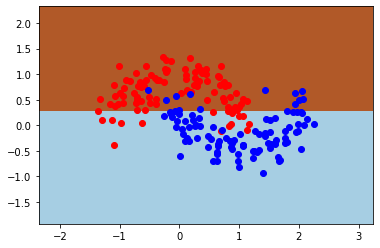

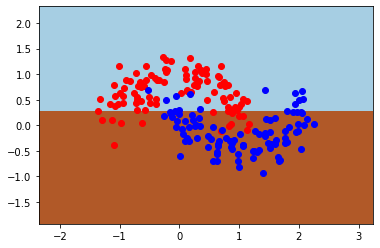

In [6]:
# Check your code
sk_stump = tree.DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=w)
my_stump = My_stump()
my_stump.fit(X, y, w)

print("Difference in the best threshold:", sk_stump.tree_.threshold[0] -  my_stump.get_threshold())

plot_tree(my_stump,X,y)
plot_tree(sk_stump,X,y)

## Second part: Adaboost

Implement the **AdaBoost** seen in class. You can use the ```my_stump``` implemented before. We encourage you to check the correctness by comparing it to ```sk_stump```.
- Implement the ```fit``` function in the provided template using the utility functions.

<div class='alert alert-block alert-info'>
            Code:</div>

In [7]:
import pandas as pd

# Compute the error rate of a weak classifier with weights w_m
def compute_error(y, y_pred, w_m):
    return np.sum(w_m[y_pred != y]) # TODO - your code here

# Compute alpha 
def compute_alpha(error):
    return 0.5 * np.log((1 - error) / error)# TODO - your code here

# Compute the update of the weights
def update_weights(w_i, alpha, y, y_pred, error):
    return w_i * np.exp(-alpha * y * y_pred) / (2 * np.sqrt(error * (1 - error)))# TODO - your code here


class AdaBoost:
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.loss_ensemble = []
        
    def predict(self, X):
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 
        for m in range(len(self.G_M)):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)
        return y_pred.values

    def fit(self, X, y, M = 10):
        self.alphas = [] 
        self.training_errors = []
        self.M = M
        Z=1
        for m in range(0, M):# Iterate over M weak classifiers
            if m == 0:
                w_m = np.ones(len(y)) * 1 / len(y)  
            else:
                w_m = update_weights(w_m, alpha_m, y, y_pred, error_m)
                
            G_m = DecisionTreeClassifier(max_depth=1, random_state=42)
            G_m.fit(X, y, sample_weight=w_m)
            y_pred = G_m.predict(X)
            error_m = compute_error(y, y_pred, w_m)
            alpha_m = compute_alpha(error_m)
            
            self.G_M.append(G_m) # Save to list of weak classifiers
            self.alphas.append(alpha_m)
            Z = Z * (2 * np.sqrt(error_m * (1 - error_m)))
            self.loss_ensemble.append(Z) 
        

- Run the code for 20 iterations. At each iteration, plot the result of the ensemble of AdaBoost ```ab``` using ```plot_tree(ab, X, y)```
- Plot the evolution of the loss in the 20 iterations.

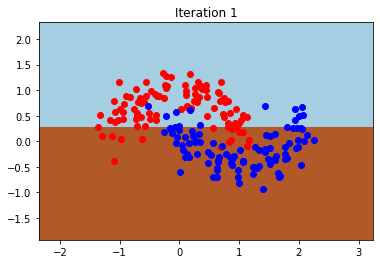

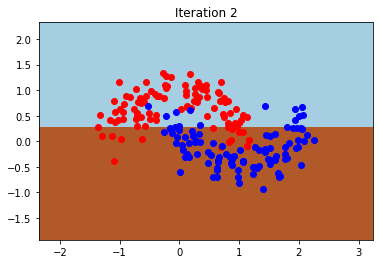

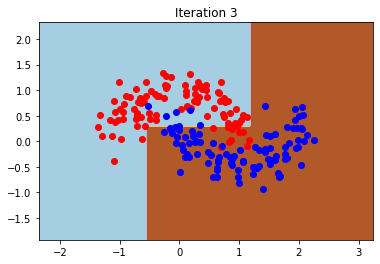

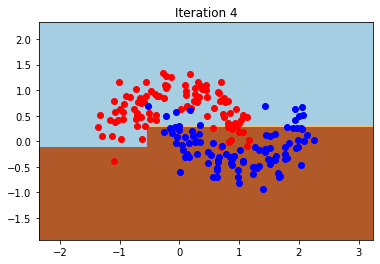

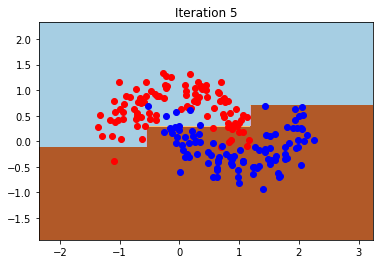

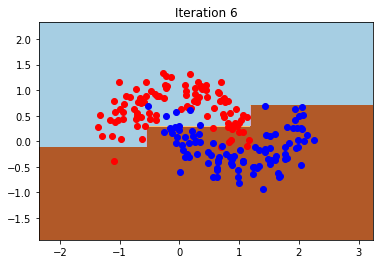

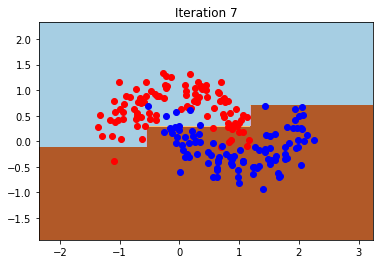

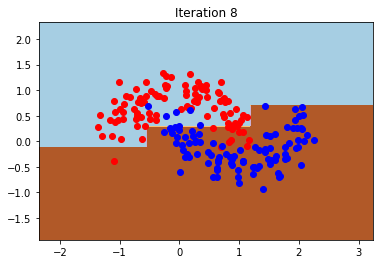

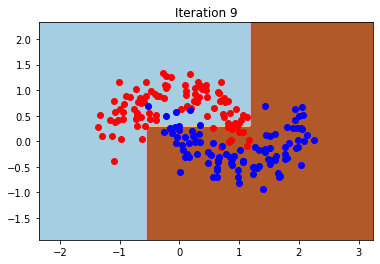

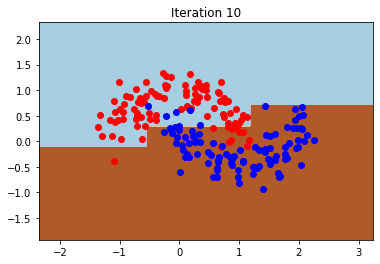

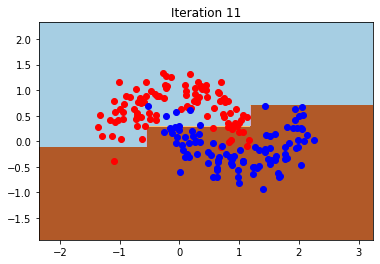

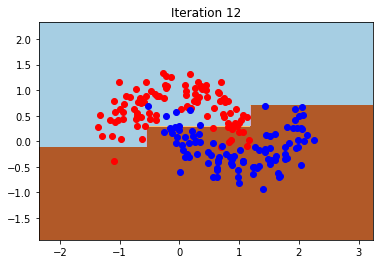

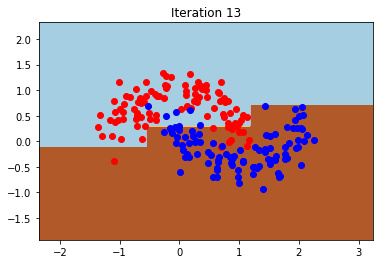

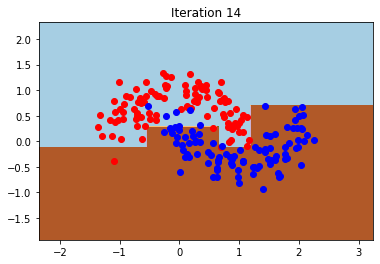

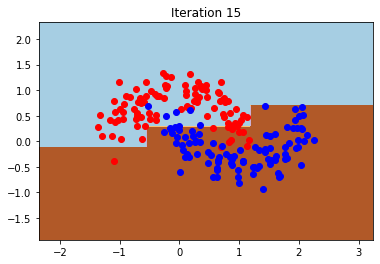

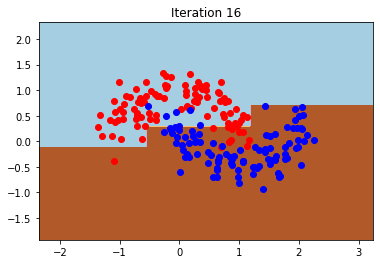

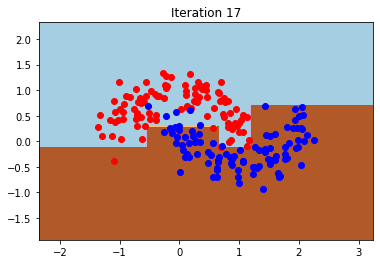

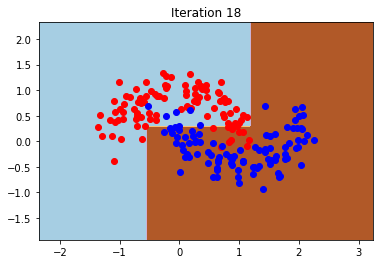

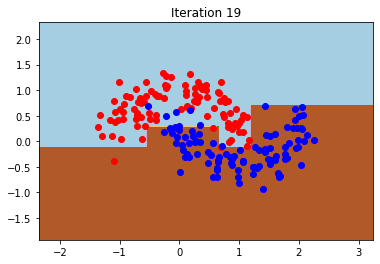

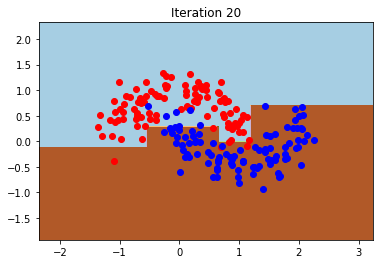

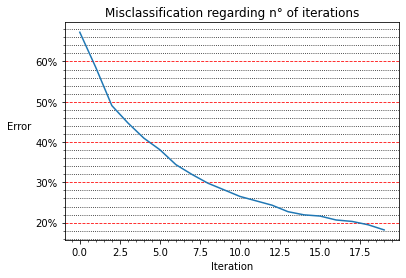

In [8]:
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

for M in range(1, 21):
    ab = AdaBoost()
    ab.fit(X, y, M)
    plot_tree(ab, X, y, label=f'Iteration {M}')
plt.plot(ab.loss_ensemble)
plt.xlabel('Iteration')
plt.ylabel('Error', rotation=0, ha='right')
plt.minorticks_on()
plt.grid(axis='y', linestyle='--', which='major', color='r')
plt.grid(axis='y', linestyle=':', which='minor', color='black')
plt.gca().set_yticklabels([f'{val:,.0%}' for val in plt.gca().get_yticks()])
plt.title('Misclassification regarding n° of iterations')
plt.show()